# DATATHON IBK 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import gc
import joblib
import pprint
from time import time
from tqdm.notebook import tqdm

from featexp import get_univariate_plots

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_theme(style="ticks")

import warnings
warnings.filterwarnings("ignore")

In [200]:
# Historial crediticio
rcc_train = pd.read_csv('data/rcc_train.csv')
rcc_test = pd.read_csv('data/rcc_test.csv')
# Información socioeconómica
se_train = pd.read_csv('data/se_train.csv',index_col='key_value')
se_test = pd.read_csv('data/se_test.csv',index_col='key_value')
# Información fiscal
sunat_train = pd.read_csv('data/sunat_train.csv')
sunat_test = pd.read_csv('data/sunat_test.csv')
# Información censal
censo_train = pd.read_csv('data/censo_train.csv',index_col='key_value')
censo_test = pd.read_csv('data/censo_test.csv',index_col='key_value')
#productos = pd.read_csv('data/productos.csv',index_col='Productos')

y_train = pd.read_csv('data/y_train.csv',index_col='key_value').target

In [201]:
rcc_train.drop_duplicates(inplace=True)
rcc_test.drop_duplicates(inplace=True)
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)
censo_train.drop_duplicates(inplace=True)
censo_test.drop_duplicates(inplace=True)

In [4]:
def diferent_vals_cat(train,test,varC):
    diferentes = {}
    uniques_train =  sorted(train[varC].unique())
    uniques_test =  sorted(test[varC].unique())
    diferentes['train'] = list(j for j in uniques_train if j not in uniques_test)
    diferentes['test'] = list(j for j in uniques_test if j not in uniques_train)
    print("*"*10, varC, "*"*10)
    print(f"Not in test: {diferentes['train']}\nNot in train: {diferentes['test']}")

In [5]:
def plot_mean_encoding(df,var):
    #df = df[[var,'target']].replace(np.nan,300)
    porcs = pd.DataFrame([[i, df[df[var]==i]['target'].sum()/df[df[var]==i].shape[0],
                           df[df[var]==i]['target'].sum()/df['target'].sum(),
                           df[df[var]==i].shape[0]/df[var].shape[0]]
                           for i in df[var].unique()])
    porcs.columns = [var,'porc_1','peso_1','peso_cat']#f'count_{var}'
    porcs.sort_values(var,inplace=True)
    porcs.set_index(var,inplace=True)
    f, ax = plt.subplots(figsize=(10,5))
    sns.lineplot(data=porcs,markers=True, dashes=False,legend=True,ax=ax,palette='mako')
    ax.grid(axis='y')

In [6]:
def corr_plot(matrix):
    f, ax = plt.subplots(figsize=(10, 7))
    mask = np.triu(np.ones_like(matrix, dtype=bool))-np.identity(matrix.shape[0])
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5},ax=ax)
    plt.show()

In [7]:
def calculate_woe(df,var):
    df = df[[var,'target']].replace(np.nan,9999)
    woe = pd.DataFrame([[i, df[df[var]==i]['target'].sum()/df[df[var]==i].shape[0],
                         df[df[var]==i].shape[0]/df[var].shape[0],
                         (df[df[var]==i]['target'].sum()+0.5)/df['target'].sum(),
                         (df[df[var]==i].shape[0]-df[df[var]==i]['target'].sum()+0.5)/df[df.target==0].target.count()]
                         for i in df[var].unique()])
    woe.columns = [var,'porc1','peso_cat','dist_1','dist_0']
    woe['woe'] = np.where(woe.dist_0>0, np.log(woe.dist_1/woe.dist_0), np.inf)
    woe['iv'] = np.where(woe.dist_0>0, (woe.dist_1-woe.dist_0)*woe.woe, np.inf)
    return woe

In [8]:
def create_woeCats(df_woe,bins,train,test):
    var = df_woe.iloc[:,[0]].columns[0]
    df_woe['grupo'] = pd.cut(df_woe.woe, bins).cat.codes
    print(df_woe.groupby('grupo')['peso_cat'].agg(['sum','count']))
    
    grupos = df_woe.groupby('grupo').sum().iloc[:,3:5]
    grupos['woe'] = np.log(grupos.dist_1/grupos.dist_0)
    grupos['iv'] = (grupos.dist_1-grupos.dist_0)*grupos.woe
    dict_grupos = dict(zip(grupos.index,grupos.woe))
    
    df_woe['grupo_woe'] = df_woe.grupo.map(dict_grupos)
    dict_var_varios = dict(zip(df_woe[var],df_woe.woe))
    dict_var_grupos = dict(zip(df_woe[var],df_woe.grupo_woe))
    
    train[f'{var}_moda'] = train[var].map(dict_var_varios)
    test[f'{var}_moda'] = test[var].map(dict_var_varios)
    
    train[f'{var}_grupos'] = train[var].map(dict_var_grupos)
    test[f'{var}_grupos'] = test[var].map(dict_var_grupos)

## Start with Credit History

In [11]:
rcc_test.PRODUCTO.replace(np.nan,255,inplace=True)
rcc_test.PRODUCTO = rcc_test.PRODUCTO.astype('int64')

In [65]:
diferent_vals_cat(rcc_train,rcc_test,'tipo_credito')

********** tipo_credito **********
Not in test: []
Not in train: [7]


In [202]:
a = pd.DataFrame(np.sort(rcc_train.saldo.unique())).diff().dropna()
a.columns = ['saldo']
coef = a.saldo.min()

In [203]:
rcc_train['saldo'] = rcc_train.saldo/coef+10000
rcc_test['saldo'] = rcc_test.saldo/coef+10000

In [ ]:
bins = [-1, 0, 10, 30, 180, 720, float("inf")]
rcc_train["condicion_cat"] = pd.cut(rcc_train.condicion, bins).cat.codes
rcc_test["condicion_cat"] = pd.cut(rcc_test.condicion, bins).cat.codes

In [ ]:
varsN = ['key_value','condicion','saldo']
varsC = ['tipo_credito','cod_instit_financiera','PRODUCTO','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR',
         'condicion_cat','key_value']

In [ ]:
moda = lambda x: pd.Series.mode(x)[0]
moda.__name__ = 'moda'

In [ ]:
def agg_rcc(df):
    global varsN, varsC
    varsD = ['saldo','condicion']
    
    aggfuncs1 = ['mean','std','min','max']
    aggfuncs2 = [moda,'nunique']
    aggfuncs3 = ['mean','std','sum']

    dfN = df[varsN].groupby(['key_value']).agg(aggfuncs1)
    dfC = df[varsC].groupby(['key_value']).agg(aggfuncs2)
    dfD = df.groupby(['key_value','codmes'])[varsD].sum().reset_index()
    for i in varsD:
        dfD[f'{i}_diff'] = dfD.groupby('key_value')[[i]].diff()
        dfD.drop(columns=i,inplace=True)
    dfD = dfD.drop(columns='codmes').groupby(['key_value']).agg(aggfuncs3)
    
    df_agg = pd.concat([dfN,dfC,dfD],axis=1)
    df_agg.columns = [a+'_'+b for a,b in df_agg.columns]
    return df_agg

In [ ]:
%%time
train = agg_rcc(rcc_train)
test = agg_rcc(rcc_test)

In [ ]:
diff_mean = lambda x: x.diff().mean()
diff_mean.__name__ = 'diff_mean'

In [ ]:
def product_diff(df):
    d = df.groupby(['key_value','codmes','PRODUCTO'])[['saldo']].sum().reset_index()
    base = pd.crosstab(d['key_value'],d['PRODUCTO'],values=d['saldo'],aggfunc=diff_mean)
    base.columns = [f"Prod_{v}_diff_mean" for v in base.columns]
    return base

In [ ]:
%%time
base_train = product_diff(rcc_train)
base_test = product_diff(rcc_test)

In [ ]:
train = train.join(base_train)
test = test.join(base_test)

del base_train, base_test
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [ ]:
def makeCt(df, c, var, aggfunc=sum):
    try:
        ct = pd.crosstab(df.key_value, df[c].fillna("N/A"), values=df[var], aggfunc=aggfunc)
    except:
        ct = pd.crosstab(df.key_value, df[c], values=df[var], aggfunc=aggfunc)
    ct.columns = [f"{c}_{v}_{aggfunc.__name__}_{var}" for v in ct.columns]
    return ct

In [ ]:
rcc_ct = []
rcc_test_ct = []
aggfuncs = [len, min, max, sum, np.mean, np.std]
aggfuncs2 = [min, max, sum, np.mean]

for c in tqdm(rcc_train.drop(columns={'codmes','key_value','saldo','condicion'}).columns):
    print('Loading', c)
    rcc_ct.extend([makeCt(rcc_train, c, 'saldo', aggfunc) for aggfunc in aggfuncs])
    rcc_test_ct.extend([makeCt(rcc_test, c, 'saldo', aggfunc) for aggfunc in aggfuncs])
    if c != 'condicion_cat':
        rcc_ct.extend([makeCt(rcc_train, c, 'condicion', aggfunc) for aggfunc in aggfuncs2])
        rcc_test_ct.extend([makeCt(rcc_test, c, 'condicion', aggfunc) for aggfunc in aggfuncs2])    
    
print('Concatenating')
rcc_ct = pd.concat(rcc_ct, axis=1)
rcc_test_ct = pd.concat(rcc_test_ct, axis=1)

In [ ]:
train = train.join(rcc_ct)
test = test.join(rcc_test_ct)

del rcc_ct, rcc_test_ct
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [122]:
prods = [1, 0, 255, 2, 3, 4, 6, 8, 5, 15, 11, 7, 13]
agg = { 'codmes':['max'],
        'saldo':['sum','count','nunique'] }
def do_rfm(df):
    rfm = df[['codmes','key_value','saldo','PRODUCTO']]
    rfm = df[df.PRODUCTO.isin(prods)].drop_duplicates()
    rfm = rfm.groupby(['key_value','PRODUCTO']).agg(agg)
    rfm.columns = [a+'_'+b for a,b in rfm.columns]

    rfm['varSaldoRegistro'] = rfm.saldo_nunique / rfm.saldo_count
    rfm['frecuency'] = rfm.saldo_count * (rfm.varSaldoRegistro ** 2)
    rfm.drop(columns=['saldo_count','saldo_nunique','varSaldoRegistro'],inplace=True)
    rfm.columns = ['recency','monetary','frecuency']

    rfm.recency = rfm.recency.max() - rfm.recency
    rfm.recency = np.where(rfm.recency>=90,rfm.recency-88,rfm.recency)
    return rfm.reset_index().drop(columns='PRODUCTO').groupby('key_value').mean()

In [123]:
rfm_mean = do_rfm(rcc_train)
rfm_mean_test = do_rfm(rcc_test)

In [140]:
train = train.join(rfm_mean)
test = test.join(rfm_mean_test)

del rfm_mean, rfm_mean_test, rcc_train, rcc_test
gc.collect()

20

## Add SocioEconomic data

In [ ]:
varsN = ['edad','ctd_hijos','ctd_veh']
varsC = ['sexo','est_cvl','sit_lab','cod_ocu','flg_sin_email','cod_ubi','lgr_vot','prv','dto','rgn','tip_lvledu']

In [ ]:
diferent_vals_cat(se_train,se_test,'dto')

In [124]:
def impCod_ubi(df):
    cod_ubi_imp = df[pd.isnull(df.cod_ubi)]
    for x in cod_ubi_imp.lgr_vot.unique():
        busc = df[df.lgr_vot==x].groupby(['prv','dto']).agg('mean').reset_index()
        idx = cod_ubi_imp[cod_ubi_imp.lgr_vot==x].index
        for y in idx:
            prov = df.loc[y].prv
            dep = df.loc[y].dto
            val = busc[(busc.prv==prov)&(busc.dto==dep)].cod_ubi.values[0]        
            if pd.isnull(val):
                val = busc[(busc.dto==dep)].cod_ubi.mean()
                if pd.isnull(val):
                    val = busc[(busc.prv==prov)].cod_ubi.mean()
                    if pd.isnull(val):
                        val = busc.cod_ubi.mean()
            df.loc[y,'cod_ubi'] = val

In [125]:
impCod_ubi(se_train)
impCod_ubi(se_test)

In [126]:
def impEdad(df):
    imp = IterativeImputer(max_iter=10, random_state=0)
    #imp.fit(df.drop(columns={'cod_ubi','lgr_vot','prv','dto','rgn'}))
    imp.fit(df)
    edad_null = df[pd.isnull(df.edad)]
    df.loc[edad_null.index,'edad'] = imp.transform(edad_null)[:,0]

In [127]:
impEdad(se_train)
impEdad(se_test)

In [ ]:
train = train.join(se_train)
test = test.join(se_test)

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

## Add Tributary data

In [ ]:
sunat_train['tiempo'] = sunat_train.fecbaja - sunat_train.fecalta
sunat_test['tiempo'] = sunat_test.fecbaja - sunat_test.fecalta

sunat_train['activo'] = np.where(pd.isnull(sunat_train.fecbaja),1,0)
sunat_test['activo'] = np.where(pd.isnull(sunat_test.fecbaja),1,0)

sunat_train['fecbaja_act'] = sunat_train['fecbaja'].replace(np.nan,sunat_train['fecbaja'].max())
sunat_test['fecbaja_act'] = sunat_test['fecbaja'].replace(np.nan,sunat_test['fecbaja'].max())

sunat_train['tiempo_tot'] = sunat_train.fecbaja_act - sunat_train.fecalta
sunat_test['tiempo_tot'] = sunat_test.fecbaja_act - sunat_test.fecalta

In [ ]:
varsN = ['fecalta','fecbaja','tiempo','fecbaja_act','tiempo_tot','key_value']
varsC = ['tipcontribuyente','tippersona','ciiu','ubigeo','condiciondomicilio',
         'estadocontribuyente','codvia','codzona','contabilidad','facturacion',
        'domiciliado','comercioexterior','cargorele','codentidadtributo','estadotributo','key_value']#,'activo'

In [ ]:
diferent_vals_cat(sunat_train,sunat_test,'ciiu')

In [ ]:
def agg_sunat(df):
    global varsN
    global varsC
    
    aggfuncs1 = {'fecalta':['min'],'fecbaja_act':['max'],'tiempo_tot':['sum']}
    aggfuncs2 = [moda,'nunique']
    aggfuncs3 = {'activo':['max']}
    
    dfN = df[varsN].drop_duplicates().groupby(['key_value']).agg(aggfuncs1)
    dfC = df[varsC].groupby(['key_value']).agg(aggfuncs2)#.remove('activo')
    dfA = df.groupby(['key_value','ciiu']).agg(aggfuncs3)
    dfA = dfA.groupby(['key_value']).sum()
    
    df_agg = pd.concat([dfN,dfC,dfA],axis=1)
    df_agg.columns = [a+'_'+b for a,b in df_agg.columns]
    df_agg['tiempo_est'] = df_agg.fecbaja_act_max - df_agg.fecalta_min
    df_agg.rename(columns={'activo_max':'activoXciiu_max','tiempo_tot_sum':'tiempo_tot_efec'},inplace=True)
    return df_agg

In [ ]:
%%time
sunat_agg = agg_sunat(sunat_train)
sunat_test_agg = agg_sunat(sunat_test)

In [ ]:
train = train.join(sunat_agg)
test = test.join(sunat_test_agg)

del sunat_agg, sunat_test_agg
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [ ]:
ciiu_train = pd.crosstab(sunat_train.key_value, sunat_train.ciiu)
ciiu_test = pd.crosstab(sunat_test.key_value, sunat_test.ciiu)

ciiu_train.columns = [f'ciiu_{c}' for c in ciiu_train.columns]
ciiu_test.columns = [f'ciiu_{c}' for c in ciiu_test.columns]

In [ ]:
train = train.join(ciiu_train)
test = test.join(ciiu_test)

del ciiu_train, ciiu_test, #sunat_train, sunat_test
gc.collect()

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

## Add Censo data

In [ ]:
censo_train = pd.read_csv('data/censo_train.csv',index_col='key_value')
censo_test = pd.read_csv('data/censo_test.csv',index_col='key_value')
censo_train.drop_duplicates(inplace=True)
censo_test.drop_duplicates(inplace=True)

In [130]:
def rmv_sunat(df):
    df['pob_a_utilidad'] = df.iloc[:,20]#-df.iloc[:,21:29].sum(axis=1)
    df['pob_b_utilidad'] = df.iloc[:,29]#-df.iloc[:,30:38].sum(axis=1)
    df['pob_c_utilidad'] = df.iloc[:,38]#-df.iloc[:,39:47].sum(axis=1)
    df['pob_d_utilidad'] = df.iloc[:,47]#-df.iloc[:,48:56].sum(axis=1)
    df['pob_e_utilidad'] = df.iloc[:,56]#-df.iloc[:,57:65].sum(axis=1)
    df['pob_utilidad'] = df.iloc[:,65]-df.iloc[:,66:74].sum(axis=1)
    df.drop(df.iloc[:,20:74].columns,axis=1,inplace=True)

In [131]:
rmv_sunat(censo_train)
rmv_sunat(censo_test)

In [132]:
censose = censo_train.join(se_train)
censose_test = censo_test.join(se_test)

del se_train, se_test
gc.collect()

60

In [133]:
def agg_censo_by_dto(df,var):
    df_agg = df.groupby('dto').mean()
    df_agg = df_agg.filter(regex=var)
    if var == 'pob':
        df_agg['punt_utilidad'] = df_agg.pob_a*df_agg.pob_a_utilidad + df_agg.pob_b*df_agg.pob_b_utilidad + df_agg.pob_c*df_agg.pob_c_utilidad + df_agg.pob_d*df_agg.pob_d_utilidad + df_agg.pob_e*df_agg.pob_e_utilidad
        #df_agg['punt_utilidad'] = df_agg['punt_utilidad']/df_agg['pob']
    return df_agg.reset_index()

In [134]:
nse_dto = agg_censo_by_dto(censose,'pob')
nse_dto_test = agg_censo_by_dto(censose_test,'pob')

In [ ]:
corr_plot(nse_dto.set_index('dto').corr())

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
nse_dto.set_index('dto',inplace=True)
idx = nse_dto.index
nse_dto = pca.fit_transform(nse_dto)
nse_dto = pd.DataFrame(nse_dto,columns=['Comp1','Comp2'],index=idx)
nse_dto.reset_index(inplace=True)
print(pca.explained_variance_ratio_)

nse_dto_test.set_index('dto',inplace=True)
idx = nse_dto_test.index
nse_dto_test = pca.fit_transform(nse_dto_test)
nse_dto_test = pd.DataFrame(nse_dto_test,columns=['Comp1','Comp2'],index=idx)
nse_dto_test.reset_index(inplace=True)
print(pca.explained_variance_ratio_)

In [135]:
train = train.merge(nse_dto,on='dto',how='left')
test = test.merge(nse_dto_test,on='dto',how='left')

del nse_dto, nse_dto_test
gc.collect()

0

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
nse_dto = nse_dto.set_index('dto')
model = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
model.fit(nse_dto)
nse_dto['label'] = model.labels_

fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=nse_dto,x='Comp1',y='Comp2',hue='label');

In [136]:
ocup_dto = agg_censo_by_dto(censose,'ocup')
ocup_dto_test = agg_censo_by_dto(censose_test,'ocup')

In [ ]:
corr_plot(ocup_dto.set_index('dto').corr())

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
ocup_dto.set_index('dto',inplace=True)
idx = ocup_dto.index
ocup_dto = pca.fit_transform(ocup_dto)
ocup_dto = pd.DataFrame(ocup_dto,columns=['Comp1','Comp2'],index=idx)
ocup_dto.reset_index(inplace=True)
print(pca.explained_variance_ratio_)

ocup_dto_test.set_index('dto',inplace=True)
idx = ocup_dto_test.index
ocup_dto_test = pca.fit_transform(ocup_dto_test)
ocup_dto_test = pd.DataFrame(ocup_dto_test,columns=['Comp1','Comp2'],index=idx)
ocup_dto_test.reset_index(inplace=True)
print(pca.explained_variance_ratio_)

In [137]:
train = train.merge(ocup_dto,on='dto',how='left').set_index('key_value')
test = test.merge(ocup_dto_test,on='dto',how='left').set_index('key_value')

del ocup_dto, ocup_dto_test
gc.collect()

40

In [138]:
print(f'Train:{train.shape}\nTest:{test.shape}')

Train:(358487, 1060)
Test:(396666, 1060)


In [ ]:
for i in range(0,7):
    print(f'Pred {i}: {censo_train[censo_train.pred==i].shape[0]/censo_train.shape[0]}')

In [ ]:
for i in censo_train.flag_censo.unique():
    print(f'Pred {i}: {censo_train[censo_train.flag_censo==i].shape[0]/censo_train.shape[0]}')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=censose,x='lon_x',y='lat_y',hue='pred',ax=ax);

## Removing different columns

In [ ]:
keep_cols = list(set(train.columns).intersection(set(test.columns)))
train = train[keep_cols]
test = test[keep_cols]
len(set(train.columns) - set(test.columns)) , len(set(test.columns) - set(train.columns))

In [ ]:
train.columns = [str(c) for c in train.columns]
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))

test.columns = [str(c) for c in test.columns]
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))

In [ ]:
print(f'Train:{train.shape}\nTest:{test.shape}')

In [139]:
%%time
train.reset_index().to_csv('data/train.csv')
test.reset_index().to_csv('data/test.csv')

CPU times: user 5min 17s, sys: 9.31 s, total: 5min 26s
Wall time: 5min 32s


In [129]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.iloc[:,1:].set_index('key_value')
test = test.iloc[:,1:].set_index('key_value')

## Target Encoding

In [ ]:
varsEnco = ['tippersona_moda','estadocontribuyente_moda','codzona_moda','tipcontribuyente_moda',
         'contabilidad_moda','facturacion_moda','domiciliado_moda','ubigeo_moda','codentidadtributo_moda',
         'ciiu_moda', 'condiciondomicilio_moda', 'estadotributo_moda','tipo_credito_moda',
         'COD_CLASIFICACION_DEUDOR_moda', 'PRODUCTO_moda','cargorele_moda','cod_instit_financiera_moda',
         'RIESGO_DIRECTO_moda','codvia_moda','comercioexterior_moda','condicion_cat_moda',
         'sexo','est_cvl','sit_lab','cod_ocu','flg_sin_email','cod_ubi','lgr_vot','prv','dto',
         'rgn','tip_lvledu']

In [ ]:
varsEnco = ['PRODUCTO_moda','COD_CLASIFICACION_DEUDOR_moda','cod_instit_financiera_moda',
             'sit_lab','cod_ubi','dto','ubigeo_moda','prv','condicion_cat_moda','lgr_vot',
             'ciiu_moda','tip_lvledu','rgn']

In [ ]:
varsEnco = ['PRODUCTO_moda','COD_CLASIFICACION_DEUDOR_moda','cod_instit_financiera_moda',
            'ciiu_moda','sit_lab','cod_ubi','condicion_cat_moda']

In [ ]:
iv_dict = {}
for i in varsEnco:
    df = calculate_woe(train[varsEnco].join(y_train),i)
    iv_dict[i] = df.iv.sum()
iv_dict = {k: v for k, v in sorted(iv_dict.items(), key=lambda i: i[1], reverse=True)}
iv_dict

In [ ]:
#encoder = ce.GLMMEncoder(cols=varsEnco)
encoder = ce.CatBoostEncoder(cols=varsEnco)
#encoder = ce.BackwardDifferenceEncoder(cols=varsEnco)
#encoder = ce.HashingEncoder(cols=varsEnco)
encoder = ce.HelmertEncoder(cols=varsEnco)
encoder = ce.JamesSteinEncoder(cols=varsEnco)
encoder = ce.LeaveOneOutEncoder(cols=varsEnco)
#encoder = ce.SumEncoder(cols=varsEnco)
encoder = ce.TargetEncoder(cols=varsEnco)
encoder = ce.WOEEncoder(cols=varsEnco)

In [ ]:
def mean_encoding(data,columnas,tipo=1):
    X=data.copy()
    for i in columnas:
        if tipo==1:
            target_sum = X.groupby(i)['target'].transform('sum')
            n_objects = X.groupby(i)['target'].transform('count')
            X[i] = (target_sum - X['target']) / (n_objects - 1)
        else:
            cumsum = X.groupby(i)['target'].cumsum() - X['target']
            cumcnt = X.groupby(i).cumcount()
            X[i] = cumsum / cumcnt
        media_target = X.target.mean()
        X[i].fillna(media_target, inplace=True)
    return X

In [142]:
import category_encoders as ce
from sklearn.model_selection import KFold, StratifiedKFold

varsEnco = ['PRODUCTO_moda','COD_CLASIFICACION_DEUDOR_moda','cod_instit_financiera_moda',
            'ciiu_moda']

encoder = ce.WOEEncoder(cols=varsEnco)
encoder.fit(train,y_train)
test = encoder.transform(test)

#folds = [train.index[t] for t, v in KFold(5).split(train)]
folds = [train.index[t] for t, v in StratifiedKFold(n_splits=5,shuffle=True,random_state=0).split(train,y_train)]

nuevo = pd.DataFrame()
for i, idx in enumerate(folds):
    Xt = train.loc[idx] 
    Xv = train.drop(Xt.index)
    yt, yv = y_train.loc[Xt.index], y_train.loc[Xv.index]

    encoder = ce.WOEEncoder(cols=varsEnco)
    Xt = encoder.fit_transform(Xt,yt) 
    Xv = encoder.transform(Xv)
    nuevo = pd.concat([nuevo,Xv])
train = nuevo.copy()

del nuevo
gc.collect()

0

## Training & Testing the model

In [143]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import KFold, ParameterGrid

In [144]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False)[0:num]
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.show()
    #return feature_imp

In [ ]:
nulls = train.isna().sum().to_frame('nulos').sort_values('nulos',ascending=False)
nulls['nulos'] = nulls.nulos/train.shape[0]*100

In [218]:
cols = nulls[nulls.nulos>=90].index
cols

Index(['PRODUCTO_41_max_condicion', 'PRODUCTO_40_min_condicion',
       'PRODUCTO_40_min_saldo', 'Prod_33_diff_mean',
       'PRODUCTO_41_sum_condicion', 'PRODUCTO_41_min_condicion',
       'PRODUCTO_41_mean_condicion', 'PRODUCTO_41_max_saldo',
       'PRODUCTO_40_len_saldo', 'PRODUCTO_40_max_saldo',
       ...
       'PRODUCTO_13_std_saldo', 'PRODUCTO_9_mean_saldo',
       'PRODUCTO_9_max_saldo', 'PRODUCTO_9_max_condicion',
       'PRODUCTO_9_min_saldo', 'PRODUCTO_9_len_saldo',
       'PRODUCTO_9_min_condicion', 'PRODUCTO_9_mean_condicion',
       'PRODUCTO_9_sum_condicion', 'PRODUCTO_9_sum_saldo'],
      dtype='object', length=457)

In [220]:
train = train.drop(columns=cols)
test = test.drop(columns=cols)

### LightGBM

In [221]:
params = ParameterGrid({'num_leaves':[50],'learning_rate':[0.05]})

In [222]:
%%time
best_score = 0
best_probs = []
for param in params:
    test_probs = []
    train_probs = []
    p  = '///'.join([f'{k}={v}' for k, v in param.items()])
    print('*'*10, p, '*'*10)
    for i, idx in tqdm(enumerate(folds)):
        Xt = train.loc[idx] 
        Xv = train.drop(Xt.index)
        yt, yv = y_train.loc[Xt.index], y_train.loc[Xv.index]
        
        learner = LGBMClassifier(n_estimators=2000,objective='binary',metric='auc',
                                 min_child_samples=1250,**param)#learning_rate=0.05,
        learner.fit(Xt,yt, early_stopping_rounds=20,eval_metric='auc',eval_set=[(Xt,yt),(Xv,yv)],verbose=False)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name='fold_' + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name='probs'))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    score = roc_auc_score(y_train, train_probs.loc[y_train.index])
    print(f'roc auc estimado: {score}\nbest iteration: {learner.best_iteration_}')
    if score > best_score:
        print('*'*10, f'{p} es el nuevo mejor modelo', '*'*10)
        best_score = score
        best_probs = test_probs

********** learning_rate=0.05///num_leaves=50 **********


|          | 0/? [00:00<?, ?it/s]

ValueError: Number of features of the model must match the input. Model n_features_ is 610 and input n_features is 606 

In [ ]:
import shap

explainer = shap.TreeExplainer(learner)
shap_values = explainer.shap_values(train)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

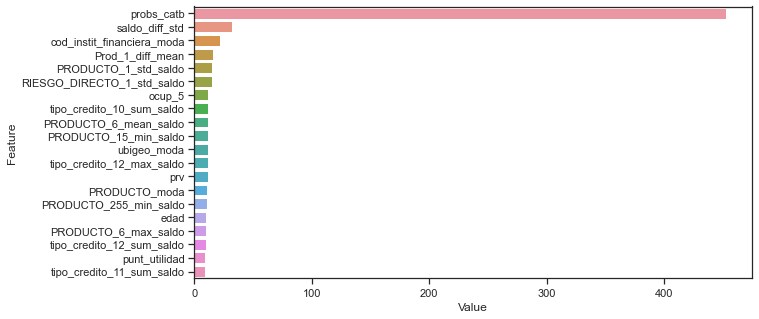

In [199]:
plotImp(learner,train,num=20)
#features = features.Feature.tolist()
#train = train[features]
#test = test[features]

In [ ]:
%%time
best_score = 0
best_probs = []
for param in params:
    test_probs = []
    train_probs = []
    p  = '///'.join([f'{k}={v}' for k, v in param.items()])
    print('*'*10, p, '*'*10)
    for i, idx in tqdm(enumerate(folds)):
        Xt = train.loc[idx] 
        Xv = train.drop(Xt.index)
        yt, yv = y_train.loc[Xt.index], y_train.loc[Xv.index]

        learner = LGBMClassifier(n_estimators=1500,n_jobs=-1,**param)#is_unbalance=True
        learner.fit(Xt,yt, early_stopping_rounds=20,eval_metric='auc',
                    eval_set=[(Xt,yt),(Xv,yv)],verbose=False)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name='fold_' + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name='probs'))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    score = roc_auc_score(y_train, train_probs.loc[y_train.index])
    print(f'roc auc estimado: {score}\nbest iteration: {learner.best_iteration_}')
    if score > best_score:
        print('*'*10, f'{p} es el nuevo mejor modelo', '*'*10)
        best_score = score
        best_probs = test_probs

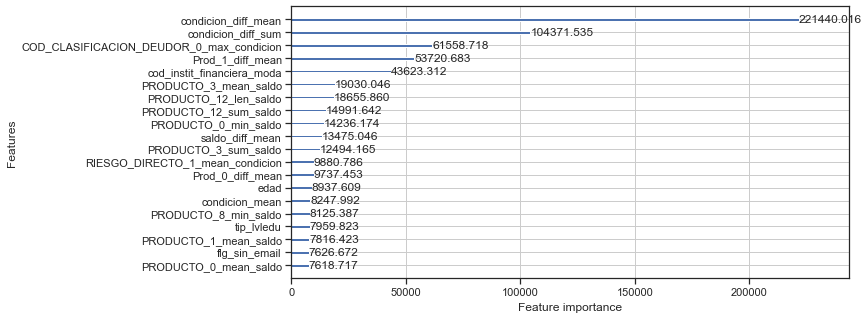

In [149]:
from lightgbm import plot_importance, plot_split_value_histogram, plot_metric
plot_importance(learner,max_num_features=20,importance_type='gain',figsize=(10,5),title='');

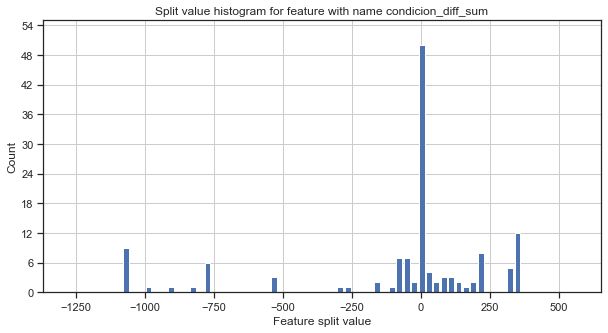

In [150]:
plot_split_value_histogram(learner,feature='condicion_diff_sum',figsize=(10,5));

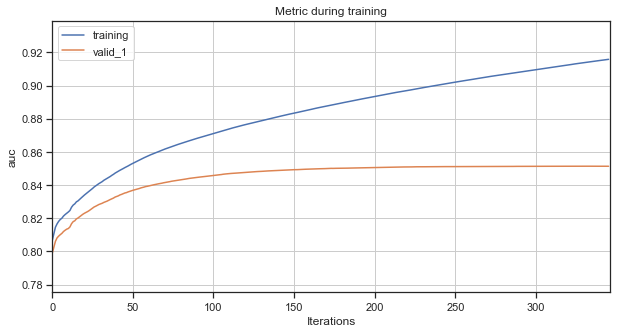

In [151]:
plot_metric(learner,metric=None,figsize=(10,5));

In [152]:
best_probs.name = 'target'
best_probs.to_csv("submissions/submission_lgbm.csv")

In [26]:
from scipy.stats import randint
from scipy.stats import uniform

from sklearn.metrics import make_scorer

In [27]:
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [28]:
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [30]:
avg_roc = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

In [31]:
clf = LGBMClassifier(boosting_type='gbdt',objective='binary',n_jobs=-1,verbose=0)

search_spaces = {
        'learning_rate': Real(0.01, 0.5, 'log-uniform'),
        'num_leaves': Integer(2, 500),
        'max_depth': Integer(0, 500),
        'min_child_samples': Integer(0, 1500), # minimal number of data in one leaf
        'min_child_weight': Integer(0, 10), # minimal number of data in one leaf.
        'n_estimators': Integer(10, 5000)        
        }

opt = BayesSearchCV(clf,search_spaces,scoring=avg_roc,cv=skf,n_iter=20,
                    n_jobs=-1,return_train_score=False,refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},random_state=22)
    
best_params = report_perf(opt, train, y_train,'LightGBM', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*3)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.995978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM took 15811.53 seconds,  candidates checked: 1, best CV score: 0.502 ± 0.003
Best parameters:
OrderedDict([('colsample_bytree', 0.3706219857878677),
             ('learning_rate', 0.16624226726409647),
             ('max_bin', 93400),
             ('max_depth', 134),
             ('min_child_samples', 130),
             ('min_child_weight', 4),
             ('n_estimators', 8028),
             ('num_leaves', 27),
             ('reg_alpha', 1.081049236893711e-05),
             ('reg_lambda', 1.043686239159047),
           

In [154]:
print(f'Train:{train.shape}\nTest:{test.shape}')

Train:(358487, 1063)
Test:(396666, 1063)


### Stacking

In [153]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [156]:
%%time
test_probs = []
train_probs = []
best_iter = []

probs_lgbm = []
probs_catb = []
probs_scik = []
test_lgbm = []
test_catb = []
test_scik = []

for i, idx in tqdm(enumerate(folds)):
    Xt = train.loc[idx]
    Xv = train.drop(Xt.index)
    yt, yv = y_train.loc[Xt.index], y_train.loc[Xv.index]

    model_lgbm = LGBMClassifier(n_estimators=2000,objective='binary',metric='auc',min_child_samples=1250,
                                num_leaves=100,learning_rate=0.01,n_jobs=-1)
    model_lgbm.fit(Xt,yt, early_stopping_rounds=30,eval_metric='auc',eval_set=[(Xt,yt),(Xv,yv)],verbose=False)
    test_lgbm.append(pd.Series(model_lgbm.predict_proba(test)[:,-1],index=test.index,name='fold_' + str(i)))
    probs_lgbm.append(pd.Series(model_lgbm.predict_proba(Xv)[:,-1],index=Xv.index,name='probs_lgbm'))
    
    model_catb = CatBoostClassifier(iterations=1200,eval_metric='AUC',max_depth=8,learning_rate=0.05,verbose=0)
    model_catb.fit(Xt,yt,early_stopping_rounds=30,eval_set=[(Xt,yt),(Xv,yv)],verbose=False)
    test_catb.append(pd.Series(model_catb.predict_proba(test)[:,-1],index=test.index,name="fold_" + str(i)))
    probs_catb.append(pd.Series(model_catb.predict_proba(Xv)[:,-1],index=Xv.index,name="probs_catb"))
    
    model_scik = HistGradientBoostingClassifier(max_iter=600,verbose=0,scoring='roc_auc',learning_rate=0.05)
    model_scik.fit(Xt,yt)
    test_scik.append(pd.Series(model_scik.predict_proba(test)[:,-1],index=test.index,name="fold_" + str(i)))
    probs_scik.append(pd.Series(model_scik.predict_proba(Xv)[:,-1],index=Xv.index,name="probs_scik"))
    
    #gnb = GaussianNB()
    #gnb.fit(Xt,yt)
    #train_probs.append(pd.Series(gnb.predict_proba(Xv)[:, -1], index=Xv.index, name="probs_gnb"))
    
    #sdg = SGDClassifier(loss="log", penalty="l2", max_iter=5)
    #sdg.fit(Xt,yt)
    #train_probs.append(pd.Series(sdg.predict_proba(Xv)[:, -1], index=Xv.index, name="probs_sdg"))
    
    best_iter.append(pd.Series(model_lgbm.best_iteration_))
    best_iter.append(pd.Series(model_catb.best_iteration_))
    best_iter.append(pd.Series(model_scik.n_iter_))
    #best_iter.append(pd.Series(gnb.best_iteration_, index='gnb'))
    #best_iter.append(pd.Series(sdg.best_iteration_, index='sdg'))

test_lgbm = pd.concat(test_lgbm, axis=1).mean(axis=1).to_frame('probs_lgbm')
test_catb = pd.concat(test_catb, axis=1).mean(axis=1).to_frame('probs_catb')
test_scik = pd.concat(test_scik, axis=1).mean(axis=1).to_frame('probs_scik')
test_probs = test_lgbm.join(test_catb).join(test_scik)
test_probs['probs_mean'] = test_probs.mean(axis=1)

probs_lgbm = pd.concat(probs_lgbm).to_frame()
probs_catb = pd.concat(probs_catb).to_frame()
probs_scik = pd.concat(probs_scik).to_frame()
train_probs = probs_lgbm.join(probs_catb).join(probs_scik)
train_probs['probs_mean'] = train_probs.mean(axis=1)

for i in train_probs.columns:
    score = roc_auc_score(y_train, train_probs.loc[y_train.index][i])
    print(f'{i}: {score}')

best_iter = pd.concat(best_iter)
print(best_iter)

|          | 0/? [00:00<?, ?it/s]

probs_lgbm: 0.8535337488777248
probs_catb: 0.85111957297493
probs_scik: 0.848756485366094
probs_mean: 0.8531889895561533
0    1666
0    1196
0     305
0    1858
0    1188
0     338
0    1563
0    1198
0     357
0    1398
0    1199
0     268
0    1452
0    1199
0     323
dtype: int64
CPU times: user 15h 36min 39s, sys: 31min 7s, total: 16h 7min 47s
Wall time: 1h 31min 43s


In [187]:
params = ParameterGrid({'C': [1,2,5,10,20]})

|          | 0/? [00:00<?, ?it/s]

C=1: 0.8519849948734305


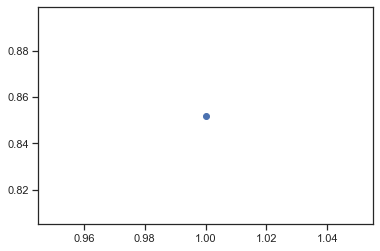

In [194]:
best_score = 0
scores = []

for param in params:
    p  = ' / '.join([f'{k}={v}' for k, v in param.items()])
    probs_stacked = []
    test_probs_stacked = []
    for i, idx in tqdm(enumerate(folds)):
        Xt = train_probs.loc[idx]
        Xv = train_probs.drop(Xt.index)
        yt, yv = y_train.loc[Xt.index], y_train.loc[Xv.index]

        log = LogisticRegression(max_iter=100,**param)
        log.fit(Xt,yt)
        test_probs_stacked.append(pd.Series(log.predict_proba(test_probs)[:,-1],index=test_probs.index,name="fold_" + str(i)))
        probs_stacked.append(pd.Series(log.predict_proba(Xv)[:,-1],index=Xv.index,name="probs_stacked"))
        
    test_probs_stacked = pd.concat(test_probs_stacked,axis=1).mean(axis=1)
    probs_stacked = pd.concat(probs_stacked).to_frame()
    score = roc_auc_score(y_train, probs_stacked.loc[y_train.index]['probs_stacked'])
    scores.append(score)
    print(f'{p}: {score}')
    
    if score > best_score:
        best_score = score
        best_probs = test_probs_stacked

plt.scatter(y=scores,x=[1,2,5,10,20]);

In [161]:
test_probs_stacked.name = 'target'
test_probs_stacked.to_csv("submissions/stacked.csv")

### XGBoost

In [ ]:
%%time
test_probs = []
train_probs = []

for i, idx in tqdm(enumerate(folds)):
    Xt = train.loc[idx]
    Xv = train.drop(Xt.index)
    yt, yv = y_train.loc[Xt.index], y_train.loc[Xv.index]

    learner = XGBClassifier(n_estimators=1500,objective='binary:logistic',n_jobs=-1,max_depth=6,learning_rate=0.05)                                
    learner.fit(Xt,yt,early_stopping_rounds=20,eval_metric='auc',eval_set=[(Xt,yt),(Xv,yv)],verbose=False)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name='fold_' + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name='probs'))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
score = roc_auc_score(y_train, train_probs.loc[y_train.index])
print(f'roc auc estimado: {score}\nbest iteration: {learner.best_iteration_}')
best_probs = test_probs